# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

### Данные

In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [4]:
trg = 'Survived'

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


3 признака имеют пропущенные значения. Причем признак 'Cabin' имеет всего 204 ненулевых значения из 889 для обучающего набора, поэтому его можно удалить. Пропущенные значения возраста - можно заполнить средними значениями. 'Embarked' имеет всего 2 пропущенных значения. Также есть 1 пропущенное значение в тестовом наборе для признака 'Fare'.

In [9]:
# пропущенные значения 'Embarked'
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Оба образца имеют значение целевой переменной '1', поэтому не будем их удалять.

Посмотрим были ли еще билеты с таким же или близким номером (13752).

In [10]:
# извлечем цифровую часть билета
train['Ticket_num'] = train['Ticket'].str.split().apply(
    lambda x: [i if i.isdigit() else 0 for i in x][-1]).astype(int)

In [11]:
# найдем наиболее близкие по номеру билеты
ids_with_close_num = np.abs(train['Ticket_num'] - 113572).sort_values().head().index
ids_with_close_num

Int64Index([61, 829, 252, 351, 54], dtype='int64')

In [12]:
train[['Ticket', 'Embarked', 'Fare']].loc[ids_with_close_num].head()

,Ticket,Embarked,Fare
61,113572,NaN,80.0000
829,113572,NaN,80.0000
252,113514,S,26.5500
351,113510,S,35.0000
54,113509,C,61.9792


In [13]:
train['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

К сожалениею, таких же или близких билетов нет, поэтому заполним пропущенные значения самым распространенным значением для признака 'Embarked' - 'S'

In [14]:
train['Embarked'].fillna('S', inplace=True)

In [15]:
# распределение целевой переменной
train['Survived'].value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

In [16]:
y_train = train[trg]

Прежде, чем удалять признак 'Ticket_num' интереса ради проверим, существуют ли счастливые билеты.

In [17]:
def lucky_num(digit):
    '''
    Функция возвращает 1, если сумма первой половины
    числа равна сумме второй половине числа (счастливый билет).
    '''
    length = len(str(digit))
    if length%2==0 and length>2:
        return int(sum(int(x) for x in str(digit)[:length//2])==
                sum(int(x) for x in str(digit)[length//2:]))
    elif length%2==1 and length>2:
        return int(sum(int(x) for x in str(digit)[:length//2+1])==
                sum(int(x) for x in str(digit)[length//2:]))
    else:
        return 0

In [18]:
train['lucky_num'] = train['Ticket_num'].apply(lucky_num)

In [19]:
len(train[(train[trg]==1) & (train['lucky_num']==1)])/\
        len(train[(train['lucky_num']==1)])

0.38181818181818183

Как видно шансы на выживание со счастливым билетом не отличаются от среднего шанса на выживание. Хотя, как гласит поверье, билет надо было съесть. В общем, нумерология не работает и признак 'Ticket_num' можно смело удалить.

Посмотрим, как влияли различные признаки на шанс выживания.

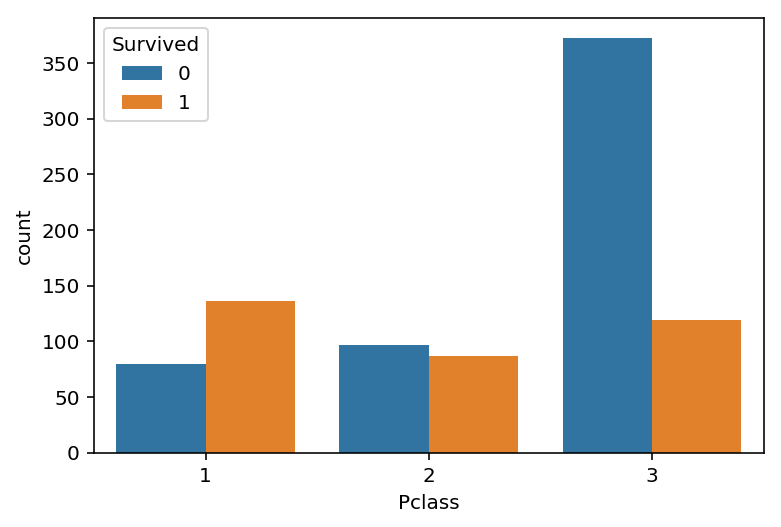

In [20]:
ax = sns.countplot(x = 'Pclass', hue = trg, data=train)

Класс сильно влиял на шанс выживания

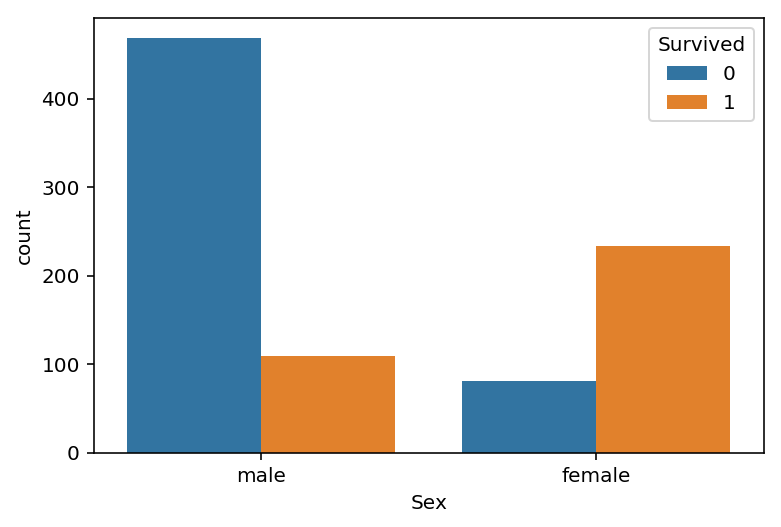

In [21]:
ax = sns.countplot(x = 'Sex', hue = trg, data=train)

Спасшихся женщин гораздо больше, чем мужчин

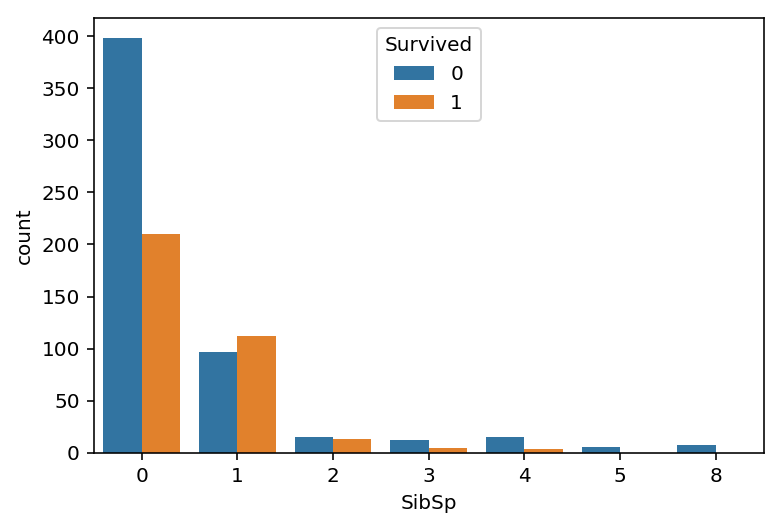

In [22]:
ax = sns.countplot(x = 'SibSp', hue = trg, data=train)

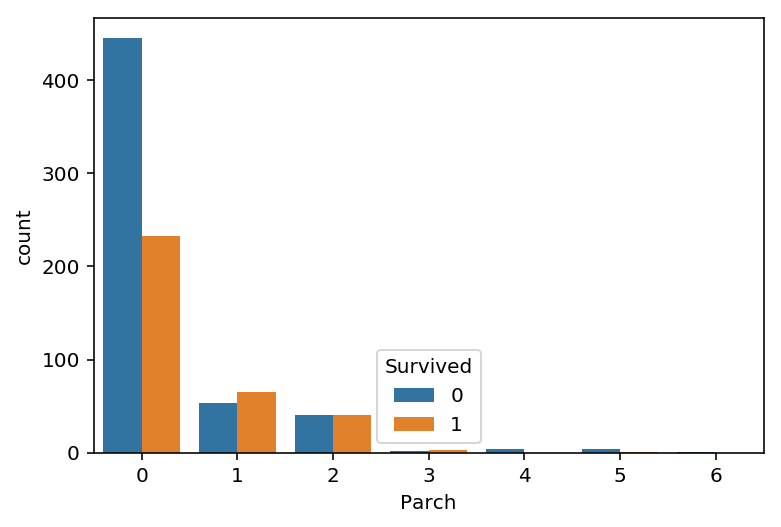

In [23]:
ax = sns.countplot(x = 'Parch', hue = trg, data=train)

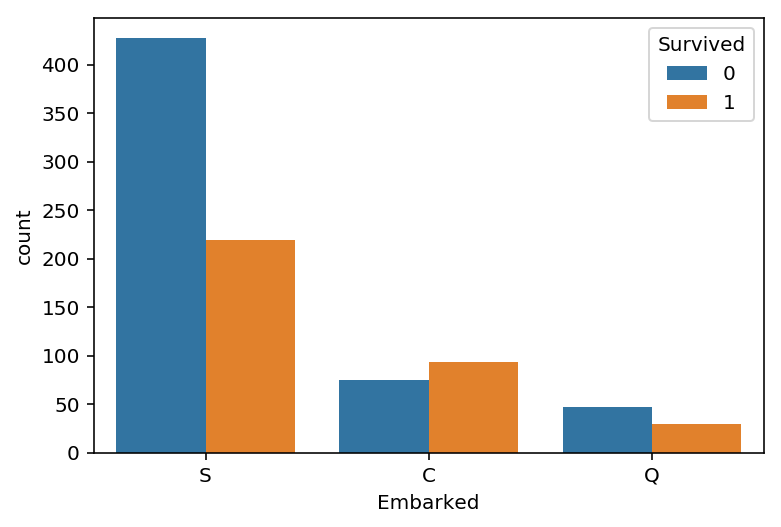

In [24]:
ax = sns.countplot(x = 'Embarked', hue = trg, data=train)

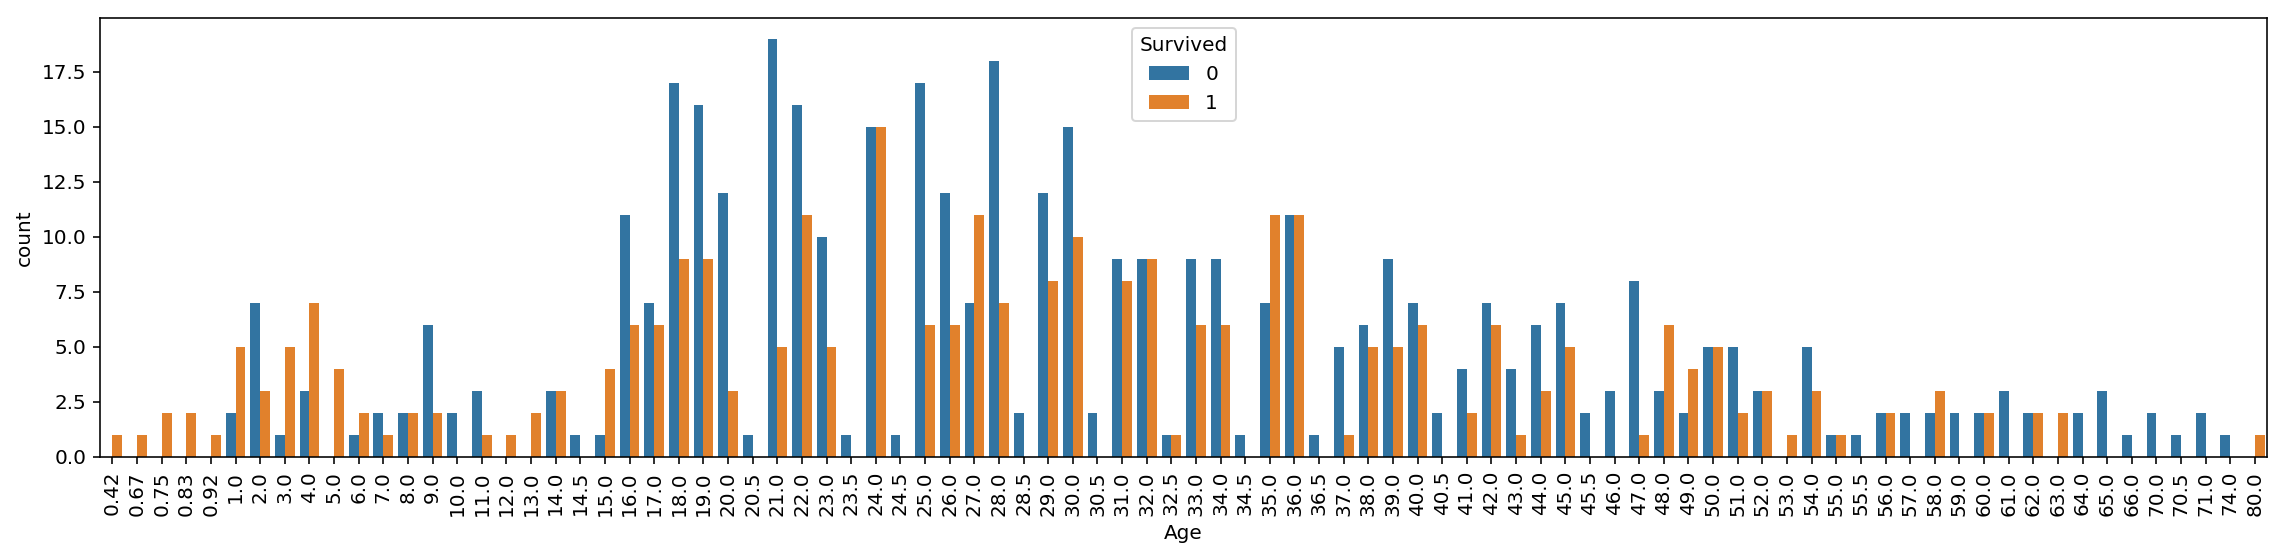

In [25]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x = 'Age', hue = trg, data=train)
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

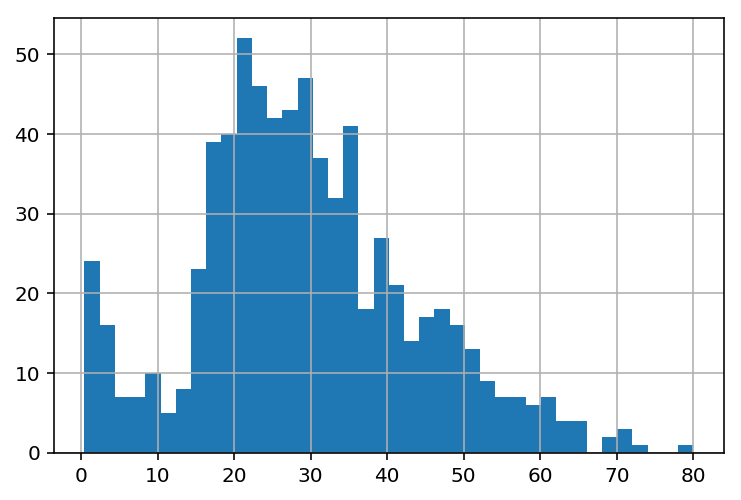

In [26]:
ax = train['Age'].hist(bins = 40)

In [27]:
train.drop(['Ticket_num', 'lucky_num'], axis=1, inplace=True)

In [28]:
test[trg] = 0
test_cols = test.columns.tolist()
test_cols = test_cols[0:1] + test_cols[-1:] + test_cols[1:-1]
test = test[test_cols]

In [29]:
all(train.columns == test.columns)

True

In [30]:
train['is_test'] = 0
test['is_test'] = 1

In [31]:
df = pd.concat([train, test])

In [32]:
df.set_index('PassengerId', inplace=True)

In [33]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [34]:
# преобразуем пол из категорий в бины.
df['isMale'] = df['Sex'].map({'male': 1, 'female': 0})

In [35]:
# выделим категорию - обращение из имени

In [36]:
all_names = sum(df['Name'].str.split(), [])
titles = [word for word in all_names if '.' in word]

In [37]:
from collections import Counter

In [38]:
titles_count = Counter(titles)
titles_count.most_common()

[('Mr.', 757),
 ('Miss.', 260),
 ('Mrs.', 197),
 ('Master.', 61),
 ('Rev.', 8),
 ('Dr.', 8),
 ('Col.', 4),
 ('Ms.', 2),
 ('Major.', 2),
 ('Mlle.', 2),
 ('Don.', 1),
 ('Mme.', 1),
 ('L.', 1),
 ('Lady.', 1),
 ('Sir.', 1),
 ('Capt.', 1),
 ('Countess.', 1),
 ('Jonkheer.', 1),
 ('Dona.', 1)]

In [39]:
titles = [title[0] for title in titles_count.most_common()]
titles.remove('L.')

In [40]:
def extract_title(string, titles):
    for title in titles:
        if title in string:
            return title
    else:
        return 'no_title'

In [41]:
df['title'] = df['Name'].apply(extract_title, titles=titles)

In [42]:
df['title'].value_counts(dropna=False)

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Ms.            2
Mlle.          2
Major.         2
Mme.           1
Sir.           1
Capt.          1
Don.           1
Lady.          1
Dona.          1
Jonkheer.      1
Countess.      1
Name: title, dtype: int64

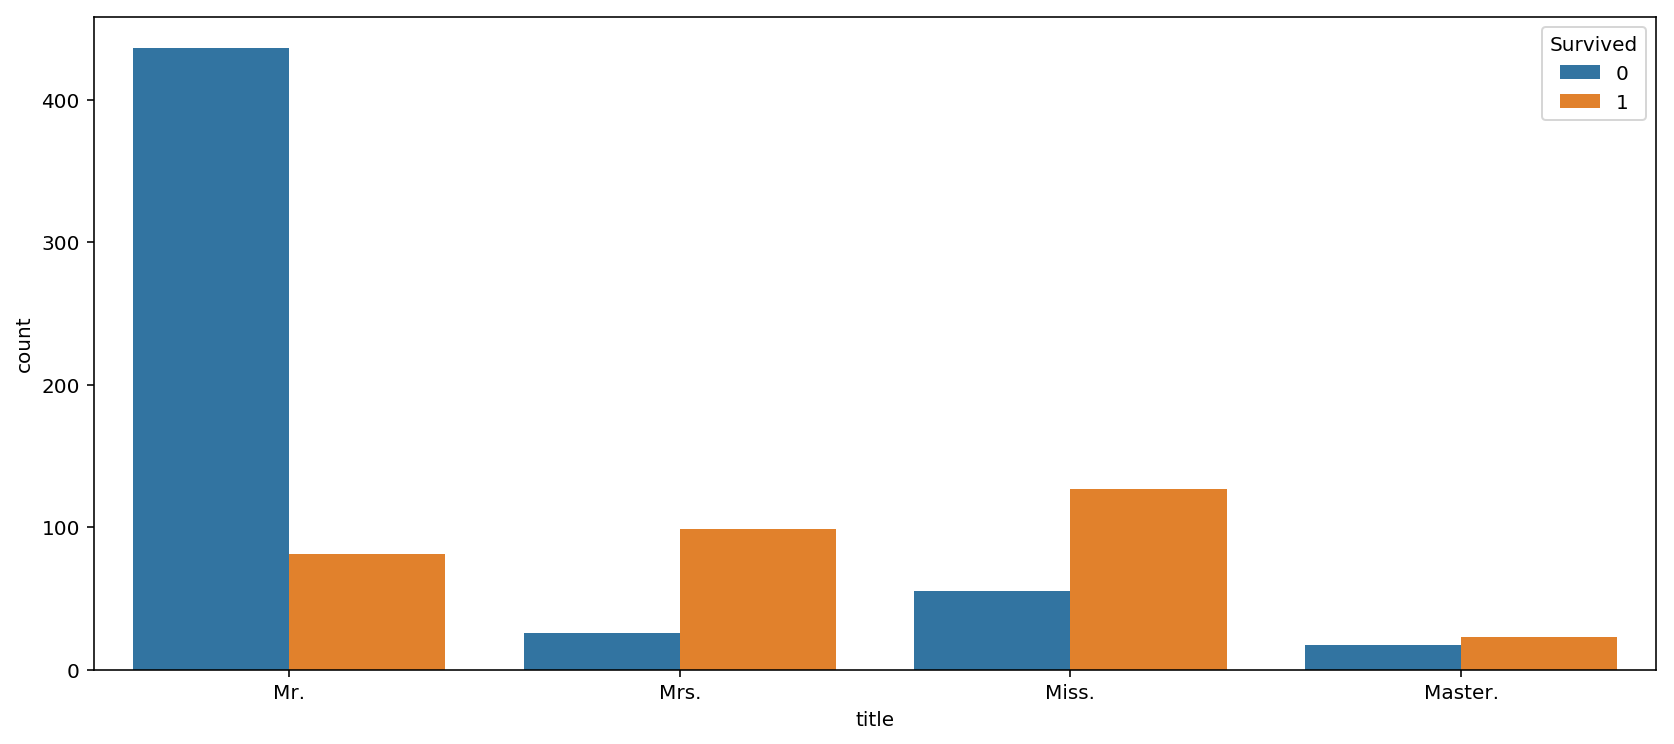

In [43]:
# посмотрим на распределение целевой переменной по титулам.
fig = plt.figure(figsize=(14,6))
ax = sns.countplot(x = 'title', hue = trg, data=df[(df['is_test']==0) & (df['title'].isin(titles[:4]))])

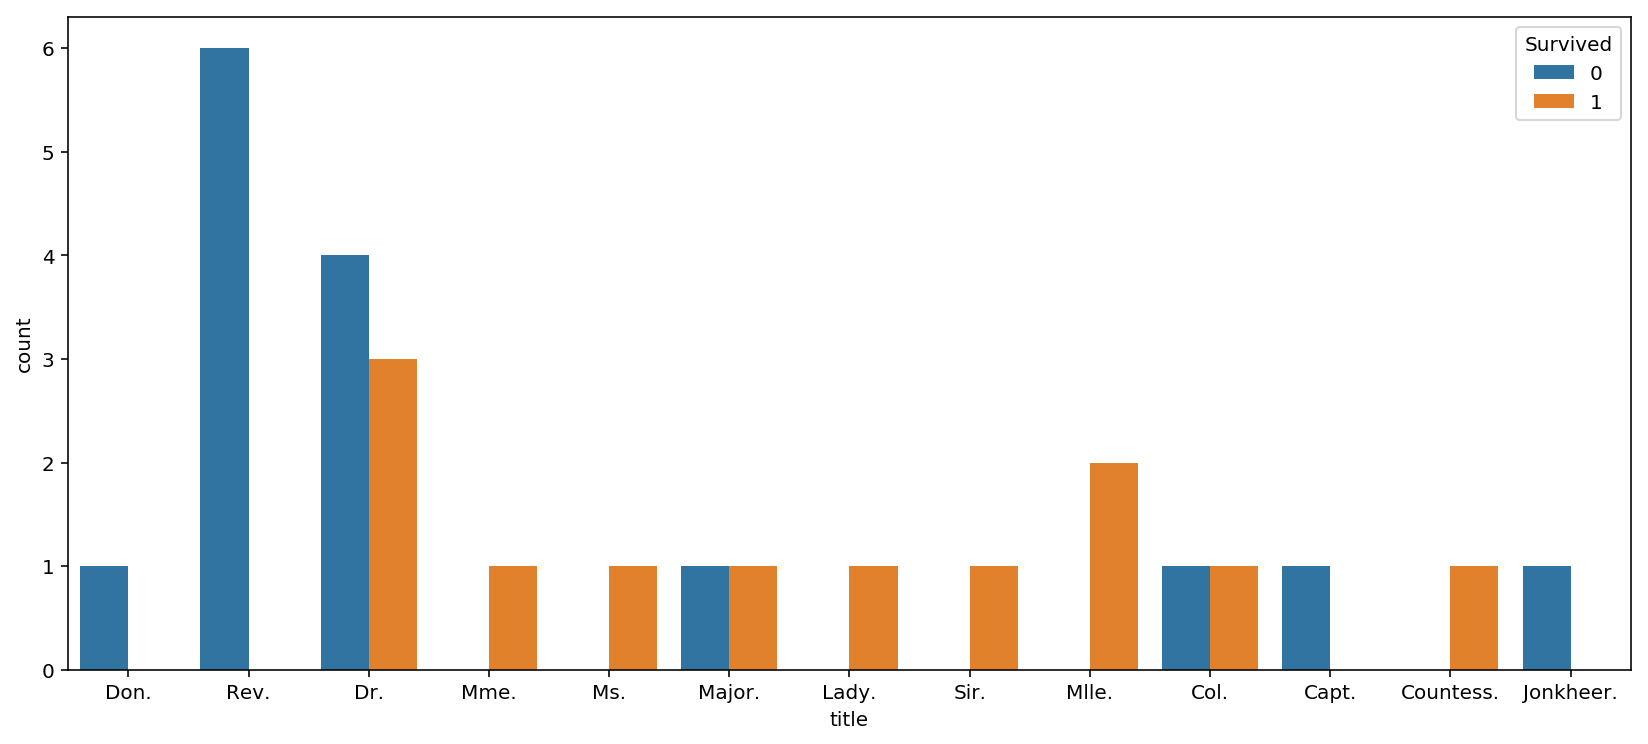

In [44]:
fig = plt.figure(figsize=(14,6))
ax = sns.countplot(x = 'title', hue = trg, data=df[(df['is_test']==0) & (df['title'].isin(titles[4:]))])

In [45]:
# присоединим некоторые редкие титулы к уже имеющимся и создадим новый - military.
title_map = {'Col.': 'military', 'Major.': 'military', 'Mlle.': 'Miss.', 'Ms.': 'Mrs.', 
            'Lady.': 'Mrs.', 'Countess.': 'Mrs.', 'Don.': 'Mr.', 'Capt.': 'Mr.', 
            'Dona.': 'Mrs.', 'Jonkheer.': 'Mr.', 'Sir.': 'Mr.', 'Mme.': 'Mrs.'}

In [46]:
df['title'].replace(title_map, inplace=True)

In [47]:
df['title'].value_counts()

Mr.         761
Miss.       262
Mrs.        203
Master.      61
Dr.           8
Rev.          8
military      6
Name: title, dtype: int64

In [48]:
# удалим ненужные признаки
df.drop(['Name', 'Sex', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [49]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_test,isMale,title
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,S,0,1,Mr.
2,1,1,38.0,1,0,71.2833,C,0,0,Mrs.
3,1,3,26.0,0,0,7.9250,S,0,0,Miss.
4,1,1,35.0,1,0,53.1000,S,0,0,Mrs.
5,0,3,35.0,0,0,8.0500,S,0,1,Mr.


Заполним пропущенные значения возраста, подобрав каждый пропущенный возраст с помощью метода K ближайших соседей.

In [98]:
temp_df = df.dropna(subset=['Fare']).drop('is_test', axis=1).copy()
temp_df = pd.get_dummies(temp_df)

In [99]:
temp_train = temp_df[temp_df['Age'].notna()].drop('Age', axis=1)
temp_test = temp_df[temp_df['Age'].isna()].drop('Age', axis=1)

In [100]:
temp_y_train = temp_df[temp_df['Age'].notna()]['Age']

In [101]:
temp_train.shape, temp_test.shape, temp_y_train .shape

((1045, 16), (263, 16), (1045,))

In [102]:
from sklearn.preprocessing import StandardScaler

In [103]:
scaler = StandardScaler()

In [104]:
temp_train_sc = scaler.fit_transform(temp_train)
temp_test_sc = scaler.transform(temp_test)

/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [105]:
from sklearn.neighbors import KNeighborsRegressor

In [106]:
clf = KNeighborsRegressor()

In [107]:
clf.fit(temp_train_sc, temp_y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [108]:
ages = clf.predict(temp_test_sc)
ages

array([37.4  , 37.6  , 25.   , 32.3  , 17.6  , 30.2  , 35.4  , 17.6  ,
       23.4  , 28.4  , 26.   , 37.4  , 17.6  , 26.   , 42.8  , 30.9  ,
        5.284, 30.2  , 26.   , 17.6  , 26.   , 26.   , 30.2  , 32.6  ,
       17.6  , 26.   , 47.8  ,  4.9  , 26.6  , 32.4  , 26.8  ,  8.1  ,
       50.   , 47.8  ,  3.6  ,  8.6  , 28.   , 43.   , 23.8  , 47.8  ,
       17.6  , 13.7  , 47.8  , 30.2  ,  8.4  , 24.4  , 15.9  , 17.6  ,
       32.4  , 45.8  , 47.8  , 26.9  , 46.3  , 17.6  , 27.6  , 47.8  ,
       30.9  , 42.8  , 17.6  , 30.1  , 20.4  , 26.   , 32.6  , 13.7  ,
       17.6  , 37.6  , 30.2  , 37.8  , 52.2  , 32.3  , 17.6  , 17.6  ,
       37.4  , 19.6  , 17.6  , 43.6  , 30.2  , 42.5  ,  8.4  , 30.2  ,
       24.   , 27.6  , 40.2  , 28.4  , 32.4  , 47.8  , 37.8  , 26.   ,
       29.5  , 26.   , 31.8  , 47.8  , 26.   , 27.6  , 42.5  , 32.4  ,
       43.   , 27.6  ,  8.4  , 29.5  , 28.1  , 25.6  , 24.1  , 41.2  ,
       26.   , 38.5  , 32.3  , 24.5  , 46.   , 24.5  , 27.   , 25.6  ,
      

In [110]:
df.loc[df['Age'].isna(), 'Age'] = ages

Аналогично поступим с пропущенным значением Fare

In [202]:
# пропущенные значения 'Fare'
test[test['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test
152,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1


In [112]:
temp_df = df.drop('is_test', axis=1).copy()
temp_df = pd.get_dummies(temp_df)

In [113]:
temp_train = temp_df[temp_df['Fare'].notna()].drop('Fare', axis=1)
temp_test = temp_df[temp_df['Fare'].isna()].drop('Fare', axis=1)

In [114]:
temp_y_train = temp_df[temp_df['Fare'].notna()]['Fare']

In [115]:
temp_train.shape, temp_test.shape, temp_y_train .shape

((1308, 16), (1, 16), (1308,))

In [116]:
from sklearn.preprocessing import StandardScaler

In [117]:
scaler = StandardScaler()

In [118]:
temp_train_sc = scaler.fit_transform(temp_train)
temp_test_sc = scaler.transform(temp_test)

/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/sergey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [120]:
clf = KNeighborsRegressor()

In [121]:
clf.fit(temp_train_sc, temp_y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [122]:
fare = clf.predict(temp_test_sc)
fare

array([7.4675])

In [123]:
df.loc[df['Fare'].isna(), 'Fare'] = fare

Преобразуем категории в OHE

In [125]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_test,isMale,title
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,S,0,1,Mr.
2,1,1,38.0,1,0,71.2833,C,0,0,Mrs.
3,1,3,26.0,0,0,7.9250,S,0,0,Miss.
4,1,1,35.0,1,0,53.1000,S,0,0,Mrs.
5,0,3,35.0,0,0,8.0500,S,0,1,Mr.


In [127]:
df_dummies = pd.get_dummies(data=df, columns=['Pclass', 'Embarked', 'title'])

In [128]:
df_dummies.head()

,Survived,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,title_Dr.,title_Master.,title_Miss.,title_Mr.,title_Mrs.,title_Rev.,title_military
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
2,1,38.0,1,0,71.2833,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,1,26.0,0,0,7.9250,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
4,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
5,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0


In [129]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 20 columns):
Survived          1309 non-null int64
Age               1309 non-null float64
SibSp             1309 non-null int64
Parch             1309 non-null int64
Fare              1309 non-null float64
is_test           1309 non-null int64
isMale            1309 non-null int64
Pclass_1          1309 non-null uint8
Pclass_2          1309 non-null uint8
Pclass_3          1309 non-null uint8
Embarked_C        1309 non-null uint8
Embarked_Q        1309 non-null uint8
Embarked_S        1309 non-null uint8
title_Dr.         1309 non-null uint8
title_Master.     1309 non-null uint8
title_Miss.       1309 non-null uint8
title_Mr.         1309 non-null uint8
title_Mrs.        1309 non-null uint8
title_Rev.        1309 non-null uint8
title_military    1309 non-null uint8
dtypes: float64(2), int64(5), uint8(13)
memory usage: 98.4 KB


In [130]:
X_train = df_dummies[df_dummies['is_test']==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies['is_test']==1].drop('is_test', axis=1)

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
# создадим стратифицированную обучающую и валидационную выборки (по целевой переменной и классу).
np.random.seed(8)
X_train_fin, X_val, y_train_fin, y_val = train_test_split(
    X_train, y_train, stratify=X_train[[trg, 'Pclass_1', 'Pclass_2', 'Pclass_3']], test_size=0.15)

In [133]:
X_train_fin.drop(trg, axis=1, inplace=True)
X_val.drop(trg, axis=1, inplace=True)
X_train.drop(trg, axis=1, inplace=True)
X_test.drop(trg, axis=1, inplace=True)

/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [134]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [135]:
np.random.seed(8)
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_fin, y_train_fin)

10

In [169]:
np.random.seed(8)
param_grid_dtc = {
        'max_depth': np.arange(3, 10),
        'max_features': ['sqrt', 'log2', None],
        'min_samples_leaf': np.arange(2, 10),
        'min_samples_split': np.arange(2, 10),
        }

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(criterion='entropy', presort=True), 
        param_grid=param_grid_dtc, scoring='accuracy', cv=skf, return_train_score=True)

In [170]:
grid_search_dtc.fit(X_train_fin, y_train_fin)

/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'max_features': ['sqrt', 'log2', None], 'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [171]:
grid_search_dtc.best_score_

0.8428005284015853

In [173]:
grid_search_dtc.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best')

In [204]:
grid_search_dtc.best_params_

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 9,
 'min_samples_split': 3}

In [205]:
results = grid_search_dtc.cv_results_

In [206]:
score_keys = [key for key in results.keys() if 'split' in key and 'test' in key]
score_keys

['split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score']

In [207]:
params_dct = {'cv_result_'+str(i): result for i, result in enumerate(
    np.array([results[score] for score in score_keys]))}

In [208]:
params_dct['model_params'] = results['params']

In [209]:
results_df = pd.DataFrame(params_dct)

In [210]:
results_df['mean_result'] = results_df.mean(axis=1)
results_df['std_result'] = results_df.std(axis=1)

In [213]:
results_df.sort_values('mean_result', ascending=False).head(10)

,cv_result_0,cv_result_1,cv_result_2,cv_result_3,cv_result_4,cv_result_5,cv_result_6,cv_result_7,cv_result_8,cv_result_9,model_params,mean_result,std_result
574,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.880000,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.842647,0.046609
575,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.880000,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.842647,0.046609
573,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.880000,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.842647,0.046609
571,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.880000,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.842647,0.046609
569,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.880000,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.842647,0.046609
572,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.866667,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.841314,0.045703
570,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.866667,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.841314,0.045703
568,0.935065,0.802632,0.881579,0.802632,0.842105,0.815789,0.866667,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.841314,0.045703
567,0.935065,0.776316,0.881579,0.802632,0.842105,0.815789,0.880000,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.840015,0.049450
566,0.935065,0.776316,0.881579,0.802632,0.842105,0.815789,0.880000,0.88,0.786667,0.8,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.840015,0.049450


In [174]:
model = grid_search_dtc.best_estimator_

In [175]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [176]:
y_train_fin_predict = model.predict(X_train_fin)
y_val_predict = model.predict(X_val)

y_train_fin_prob = model.predict_proba(X_train_fin)[:, 1]
y_val_prob = model.predict_proba(X_val)[:, 1]

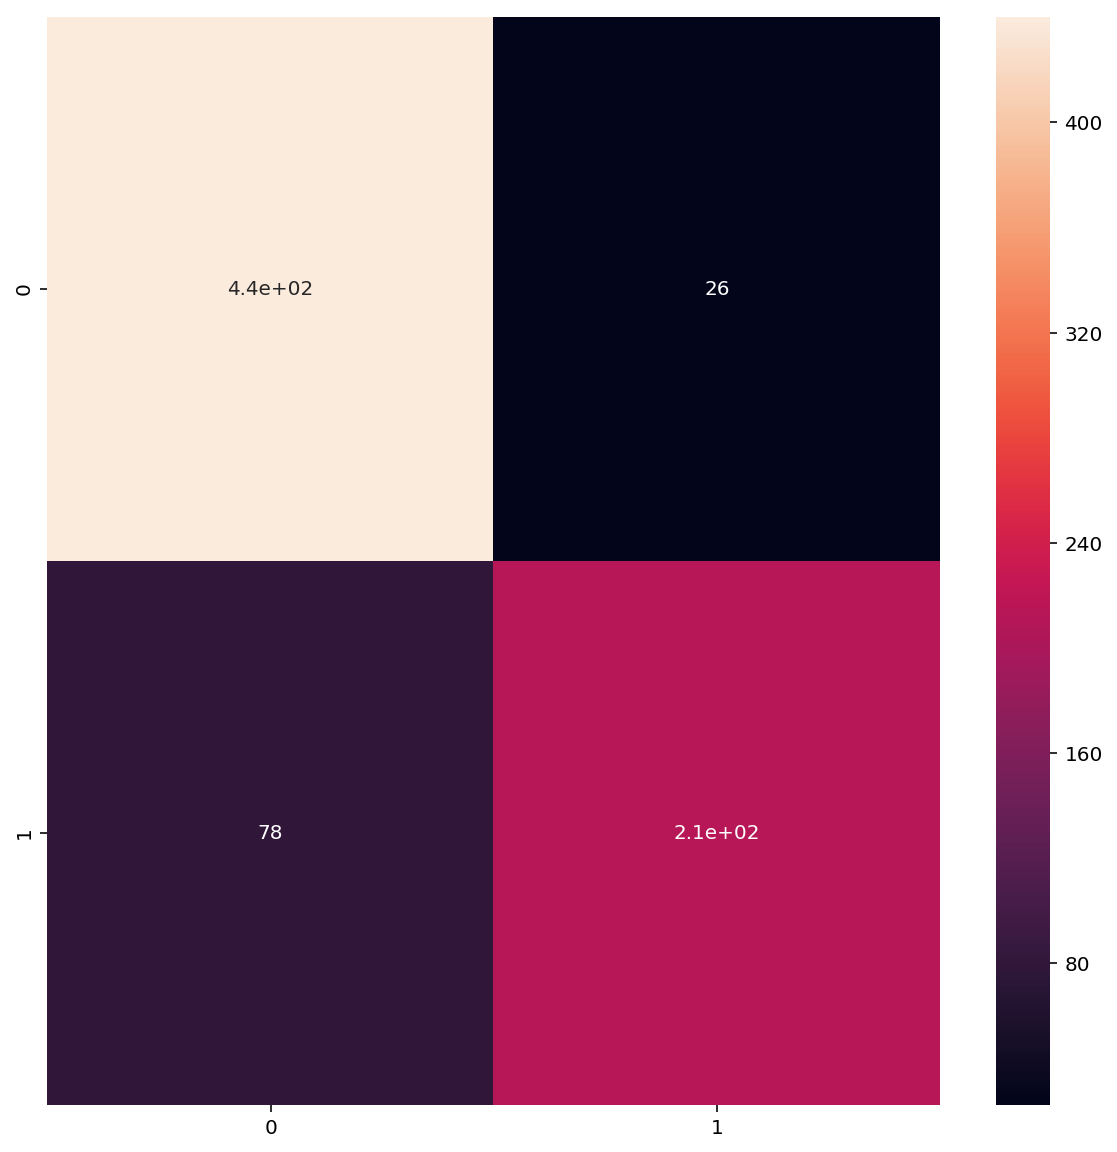

In [177]:
cm_train = confusion_matrix(y_train_fin, y_train_fin_predict)
ax = sns.heatmap(cm_train, annot=True)

In [178]:
print(classification_report(y_train_fin, y_train_fin_predict))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       466
           1       0.89      0.73      0.80       291

   micro avg       0.86      0.86      0.86       757
   macro avg       0.87      0.84      0.85       757
weighted avg       0.87      0.86      0.86       757



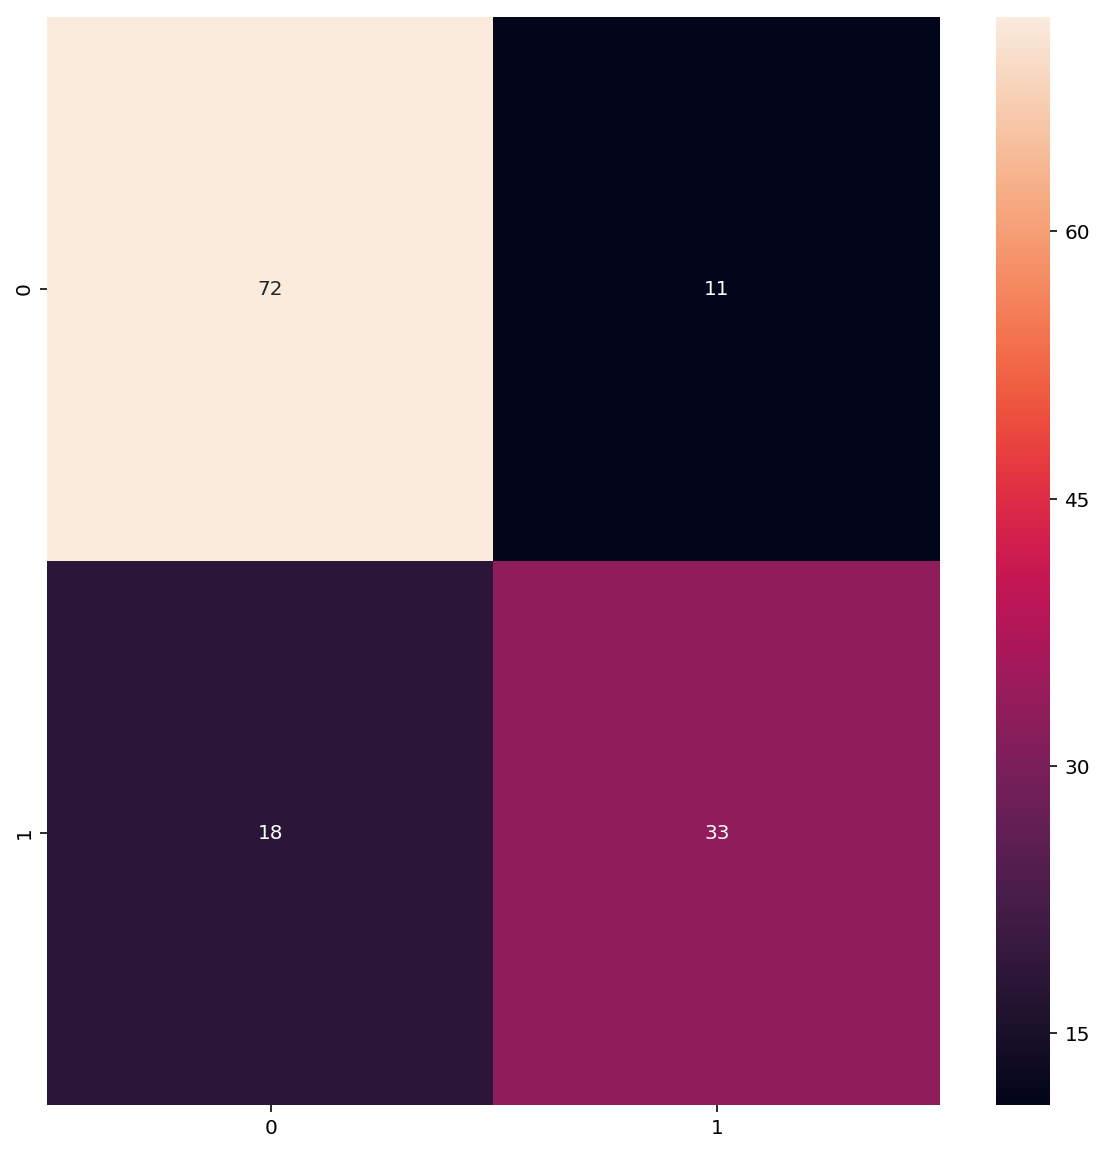

In [179]:
cm_val = confusion_matrix(y_val, y_val_predict)
ax = sns.heatmap(cm_val, annot=True)

In [180]:
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        83
           1       0.75      0.65      0.69        51

   micro avg       0.78      0.78      0.78       134
   macro avg       0.78      0.76      0.76       134
weighted avg       0.78      0.78      0.78       134



In [181]:
accuracy_train = accuracy_score(y_train_fin, y_train_fin_predict)
accuracy_val = accuracy_score(y_val, y_val_predict)
print(f'Accuracy_train: {accuracy_train:.2f}')
print(f'Accuracy_val: {accuracy_val:.2f}')

Accuracy_train: 0.86
Accuracy_val: 0.78


Наиболее важные фичи

In [182]:
sorted(zip(X_train_fin.columns, grid_search_dtc.best_estimator_.feature_importances_), 
       reverse=True, key=lambda x: x[1])

[('title_Mr.', 0.4618751564902215),
 ('Age', 0.17637822886303198),
 ('Fare', 0.17312339374434293),
 ('Pclass_3', 0.10974955589464395),
 ('isMale', 0.04798640751650417),
 ('Parch', 0.014171201287138493),
 ('SibSp', 0.011523168975518428),
 ('Embarked_S', 0.005192887228598488),
 ('Pclass_1', 0.0),
 ('Pclass_2', 0.0),
 ('Embarked_C', 0.0),
 ('Embarked_Q', 0.0),
 ('title_Dr.', 0.0),
 ('title_Master.', 0.0),
 ('title_Miss.', 0.0),
 ('title_Mrs.', 0.0),
 ('title_Rev.', 0.0),
 ('title_military', 0.0)]

In [183]:
from sklearn.tree import export_graphviz
import graphviz

In [184]:
dot_tree = export_graphviz(model, out_file=None, filled=True, feature_names=X_train_fin.columns, 
                           class_names=None)

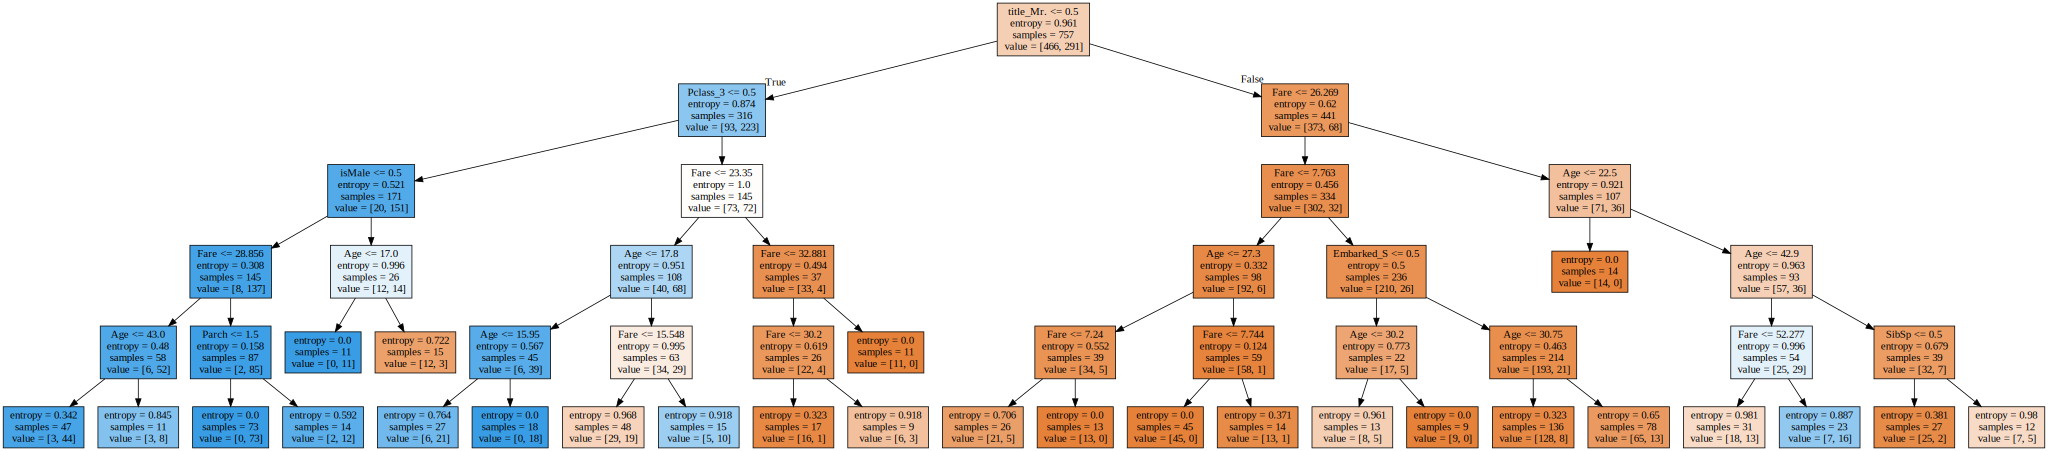

In [185]:
graph = graphviz.Source(dot_tree)
graph

In [186]:
from sklearn.metrics import roc_auc_score, roc_curve

In [187]:
roc_auc_train_fin = np.round(roc_auc_score(y_train_fin, y_train_fin_prob), 2)
roc_auc_val = np.round(roc_auc_score(y_val, y_val_prob), 2)
print("Train: ", roc_auc_train_fin)
print("Test: ", roc_auc_val)

Train:  0.93
Test:  0.85


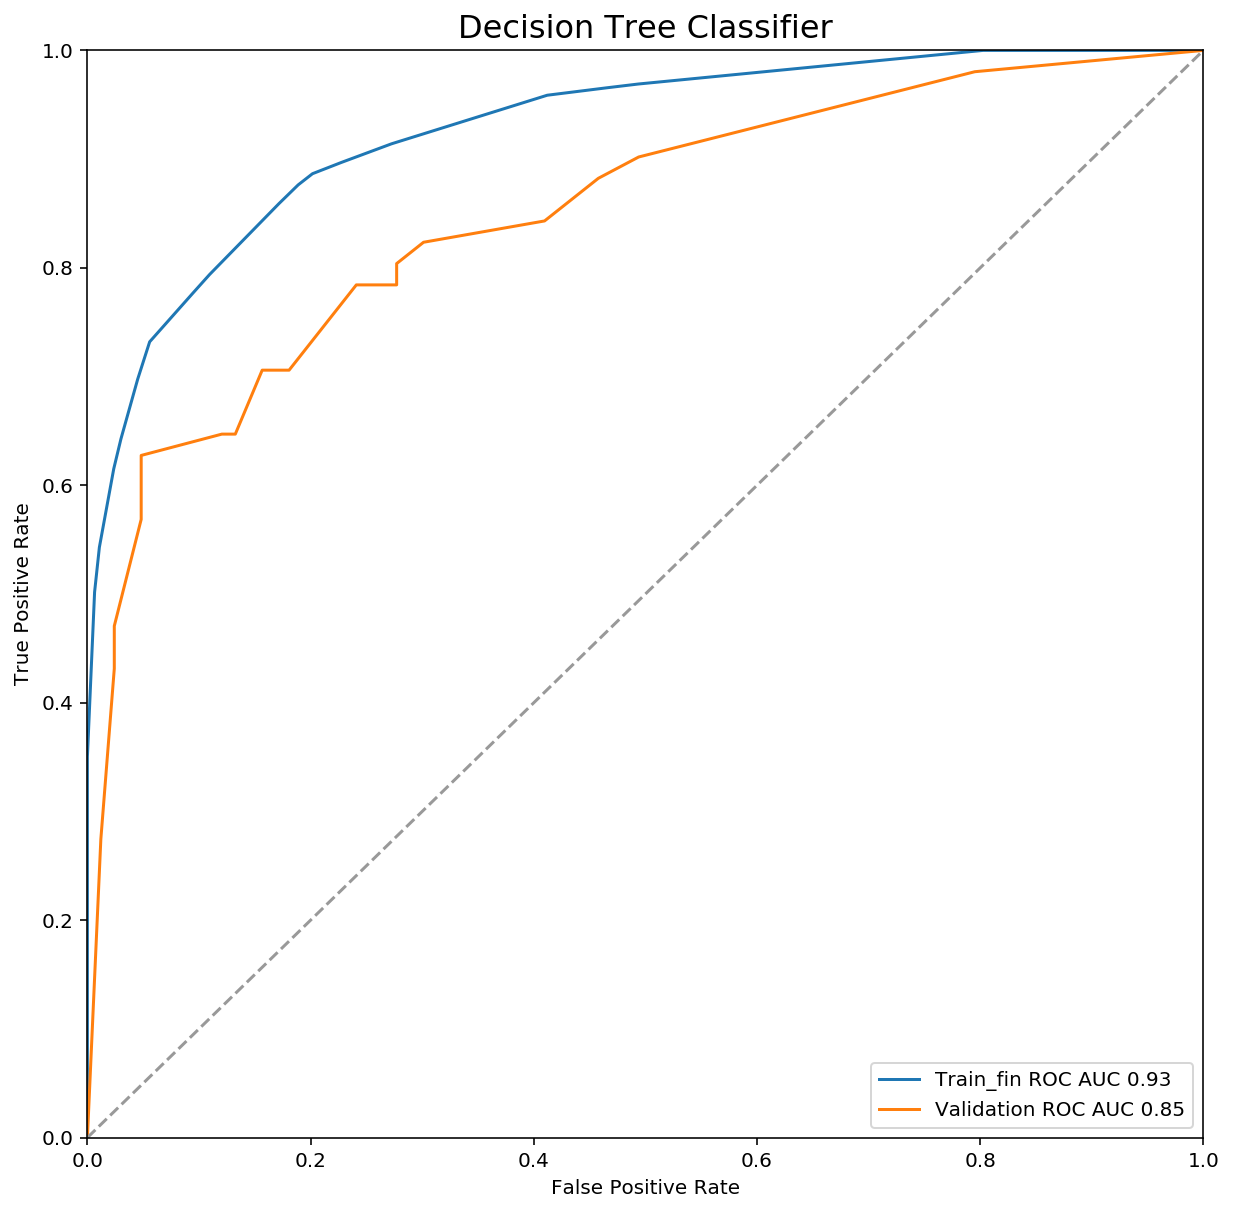

In [188]:
import matplotlib

fpr_train_fin, tpr_train_fin, thresholds_train_fin = roc_curve(y_train_fin, y_train_fin_prob)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_prob)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train_fin, tpr_train_fin, label='Train_fin ROC AUC {0}'.format(roc_auc_train_fin))
plt.plot(fpr_val, tpr_val, label='Validation ROC AUC {0}'.format(roc_auc_val))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [189]:
from sklearn.metrics import precision_recall_curve

In [190]:
precisions_val, recalls_val, thresholds_val = precision_recall_curve(y_val, y_val_prob)
precisions_train_fin, recalls_train_fin, thresholds_train_fin = precision_recall_curve(y_val, y_val_prob)

In [191]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, model='Decision Tree Classifier\n'):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Точность')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Полнота')
    plt.plot([0.5, 0.5], [0, 1])
    plt.xlabel('Порог')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.title(f'Модель: {model}')

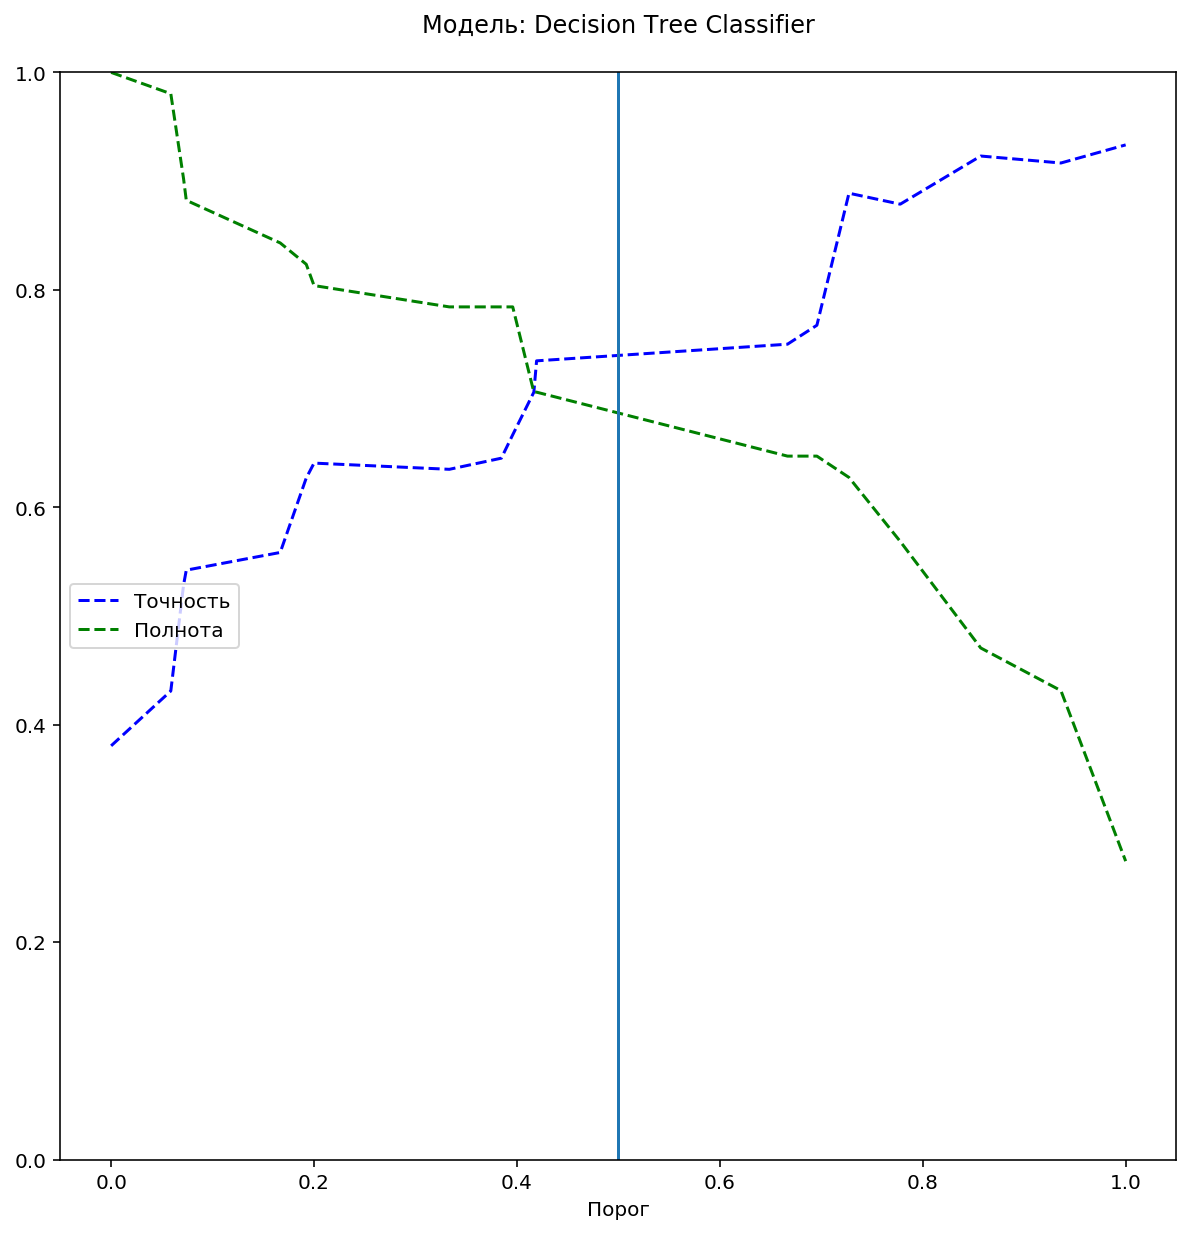

In [192]:
plot_precision_recall_vs_threshold(precisions_train_fin, recalls_train_fin, thresholds_train_fin)

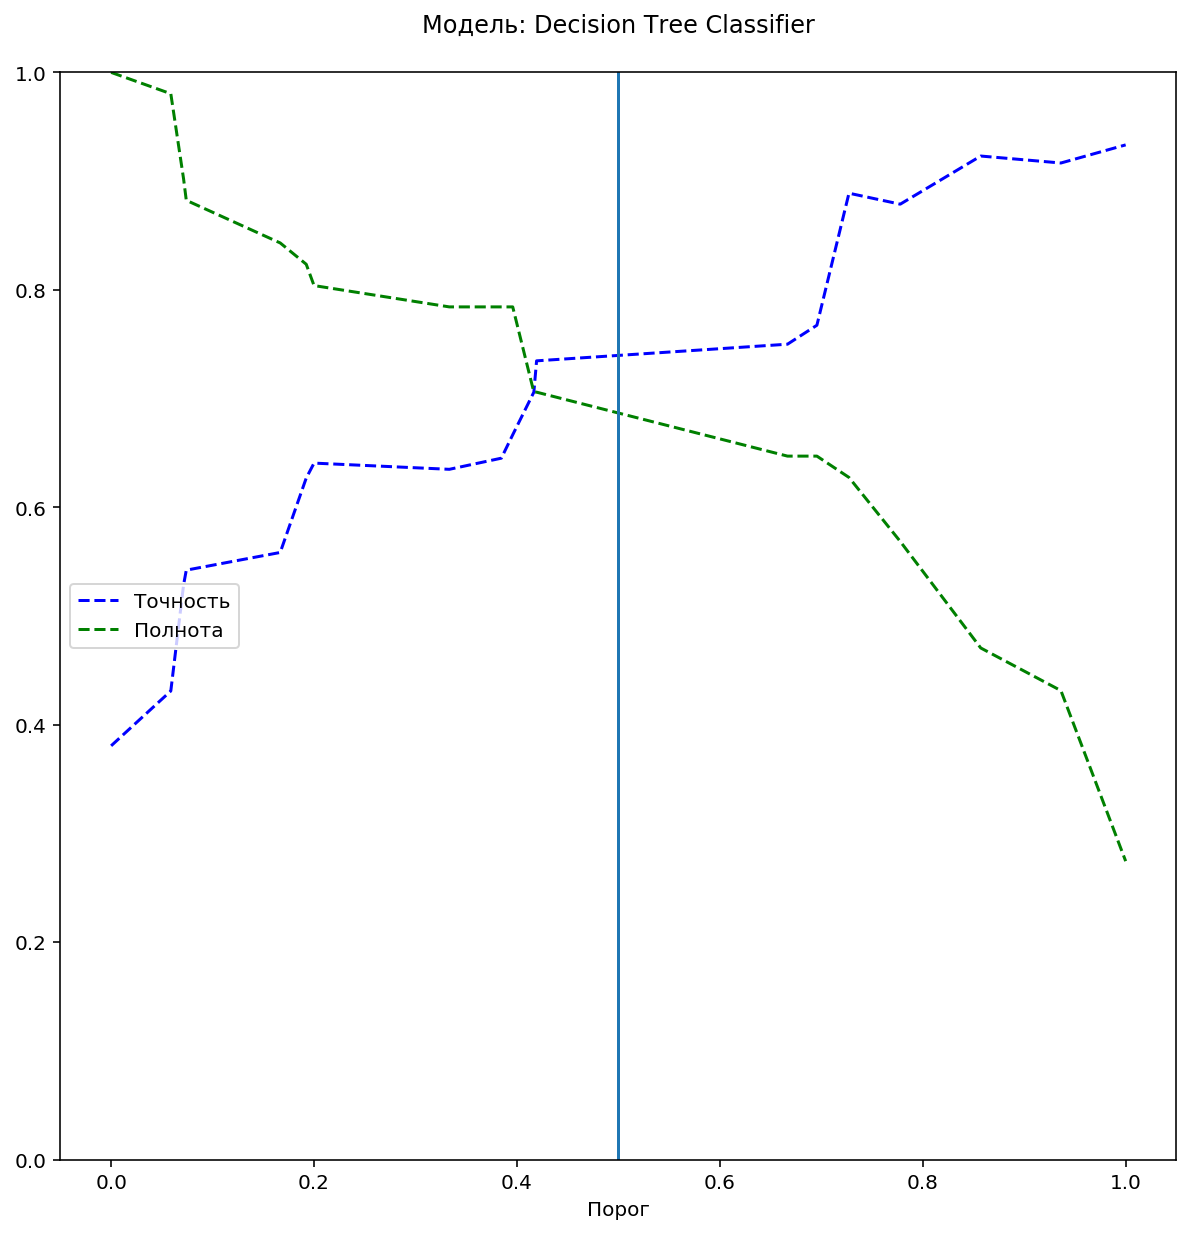

In [193]:
plot_precision_recall_vs_threshold(precisions_val, recalls_val, thresholds_val)

In [194]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best')

In [195]:
y_test_predict = model.predict(X_test)

In [196]:
y_test_predict.shape

(418,)

In [197]:
X_test.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

In [198]:
y_test_predict

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [199]:
submussion = pd.DataFrame({'PassengerId':X_test.index, 'Survived': y_test_predict})

In [200]:
submussion.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [201]:
submussion.to_csv('./submussion.csv', index=False)

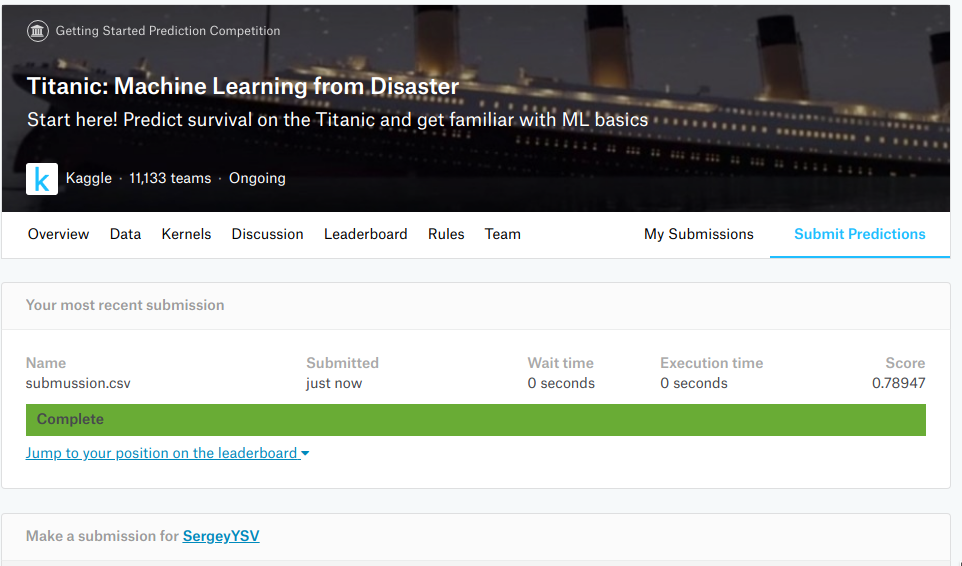

In [215]:
from IPython.display import Image
Image(filename='Screenshot_kaggle.png')